In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import scipy.stats as stats
import numpy as np


## Загрузка и неформальная проверка данных

In [2]:
# создаем подключение, проверяем, что связь есть, смотрим,
# что данные возвращаются адекватные
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220920',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

# подключились к БД и выполнили запрос по извлечению всех пользователей 
# в группе 2 и 1 в нужном временном интервале и информации по ним 
q1 = """
    SELECT exp_group
        ,  user_id
        ,  sum(action = 'like') as likes
        ,  sum(action = 'view') as views
        ,  likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-09-03' and '2022-09-09'
        and exp_group in (2,1)
    GROUP BY exp_group, user_id
    """
df = ph.read_clickhouse(q1, connection=connection)
# вывели число пользователей в получившихся группах
df.groupby('exp_group').count()


,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [3]:
df.describe()

,exp_group,user_id,likes,views,ctr
count,20031.000000,20031.000000,20031.000000,20031.000000,20031.000000
mean,1.496830,75343.140432,13.448954,66.224652,0.215016
std,0.500002,53262.345755,10.865224,45.095939,0.117862
min,1.000000,206.000000,0.000000,1.000000,0.000000
25%,1.000000,22034.000000,6.000000,32.000000,0.117021
50%,1.000000,109234.000000,11.000000,56.000000,0.195122
75%,2.000000,126220.500000,18.000000,90.000000,0.291667
max,2.000000,141164.000000,95.000000,321.000000,0.923077


In [4]:
df.head(7)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
5,2,131473,14,134,0.104478
6,2,23985,7,87,0.080460


# Задача 2

## Визуализация нужных групп, их предварительный анализ

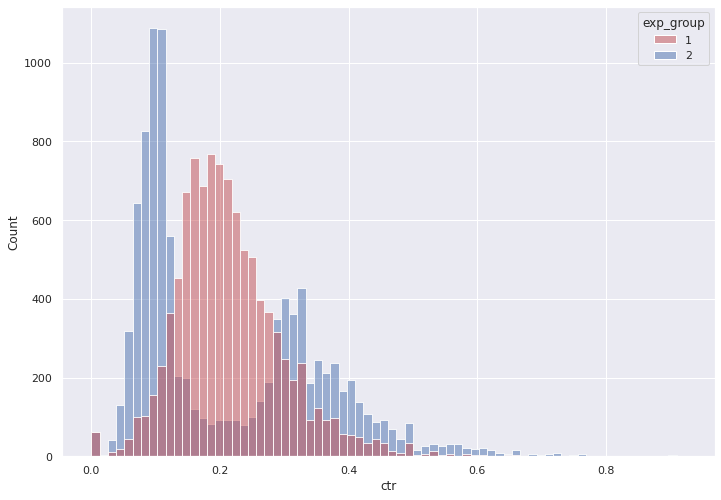

In [5]:
# гистограммы по обоим группам вместе (на одном рисунке)
# cделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)


Что видим на гистограмме:
- в первой группе распределение одномодальное, немного ассиметричное,с некоторомы выбросами в нуле и на правой стороне;
- в группе 2 распределение двумодальное - один  пик, причем более высокий (т.е. это достаточно представительная по числу пользователей группа), сместился относительно группы 1 в сторону меньших значений CTR, а второй пик представляет людей, у которых число лайков на число просмотров (т.е. CTR) увеличилось.

То есть можно сделать предварительный вывод о том, что новый алгоритм разделил пользователей на две ярко выраженных подгруппы ( в группе 2) - в  одной,  скорее меньшей (для более точного утверждения надо сравнивать площади под  соответствующими кусочками гистограмм), новшество вызвало увеличение CTR, а в другой группе - уменьшение CTR. Надо заметить, что при этом нулевые CTR ушли, хотя это может быть проявлением случайности. Т.е. части пользователей новшество понравилось, а части - нет.  

Надо заметить, что такая ситуация  двумодальности является противопоказанием применения параметрических тестов, опирающихся на значения среднего и дисперсии, в том  числе t-критерия Стьюдента. Это аналогично вычислению средней температуры по больнице, когда учитывают и морг, и находящихся в горячке - в среднем может получиться вполне "здоровая" температура. Ну и с формальной точки зрения такая ярко выраженная двумодальность максимально далека как от предположения нормальности распределения наблюдений в каждой из групп, так и подразумеваемого предположения однородности (по своим характеристикам) объектов внутри каждой из сравниваемых групп.  

И дисперсия, вычисляемая по привычной формуле (используемая в знаменателе статистики t-критерия), будет плохой оценкой истинной дисперсии в случае  двумодальной выборки, она будет больше по сравнению содномодальным случаем, что будет приводить к уменьшению значения статистики,  что, в свою очередь,  будет делать t-критерий более склонным к  тому, чтобы не отвергать гипотезу о  равенстве средних.   

## Классические АВ-тесты (t-критерий и Маннна-Уитни)

In [6]:
# получение результатов t-test по группам 1 и 2  по показателю ctr
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 1].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7094392041270486, pvalue=0.4780623130874935)

In [7]:
# получение результатов Манна-Уитни по группам 1 и 2  по показателю ctr
stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
                   df[df.exp_group == 1].ctr,
                   alternative = 'two-sided')


MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

Вывод по данным критериям в какой то степени ожидаем: 
- параметрический t-критерий не нашел различий: гипотеза о равенстве средних в группах 1 и 2 не отвергается, поскольку pvalue=0.478>0.05, где 0.05 - традиционное значене для ошибки 1 рода (уровня значимости). Но, как говорилось выше, t-критерий опирается на среднее, которое здесь будет "компромисным" средним между двумя средними значениями CTR в двух подгруппах группы 2, и это компромисное среднее будет близко к среднему в группе 1. В целом при анализе гистограмм уже было приведено обоснование того, почему в  данной ситуации нельзя опираться на результаты, полученные с помощью t-критерия.  
- непарамерический критерий отверг нулевую гипотезу (pvalue=6.037e-56<<0.05), но в данном случае это обусловлено скорее разной формой распределений (одномодальное близкое к нормальному, и двумодальное, близкое к смеси двух нормальных  распределений), а не различиями в средних показателях этих распределений.  

Общий вывод - на основании критериев и информации о виде распределений в группах нельзя утверждать, что новшество обеспечивает статистически значимо лучшие показатели по CTR. Во всяком случае, если нас интересует возможность выкатить обновление на  всех пользователей, не разделяя их (по предоставляемому функционалу) на определенные подгруппы (их характеристики можно было бы попробовать определить, разделив группу 2 на подгруппы тех, у кого CTR больше или меньше 0.2, и проведя классификацию этих подгрупп сучетом остальных доступных характеристик пользователей).

## Сглаженный CTR

In [8]:
#функция для вычисления сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr


In [9]:
# обобщенный  CTR (по группам) 
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

(global_ctr_1, global_ctr_2)

(0.20802680490126244, 0.1980601844115994)

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='smothed_ctr'>

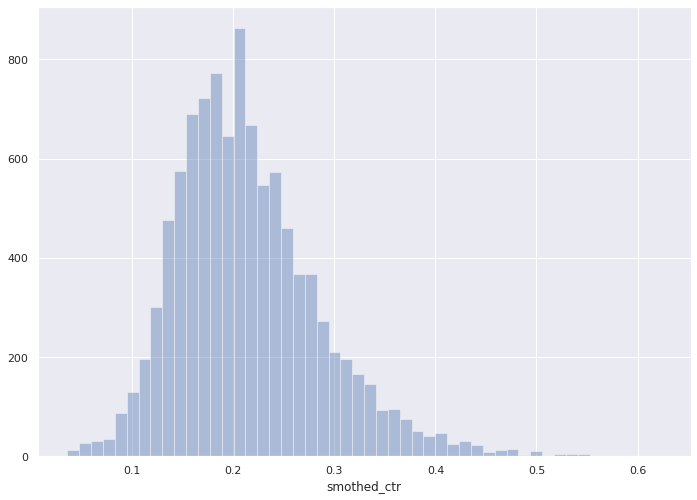

In [10]:
# сглаженный CTR (для группы 1) и гистограмма для него
group1 = df[df.exp_group == 1].copy()
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, 
             kde = False)


<AxesSubplot:xlabel='smothed_ctr'>

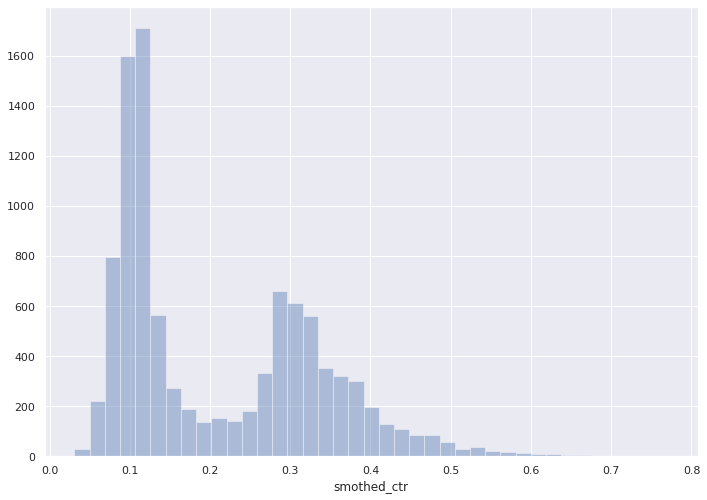

In [11]:
# сглаженный CTR (для группы 2) для альфа=5 и гистограмма для него
group2 = df[df.exp_group == 2].copy()
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr, 
             kde = False)


In [12]:
# получение результатов Манна-Уитни по группам 1 и 2  по показателю ctr
stats.mannwhitneyu(group2.smothed_ctr, 
                   group1.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43381083.0, pvalue=1.6163964114270227e-61)

Выводы:   
в данном случае применение сглаженного CTR сгладило ситуацию с выбросами (например,  в районе 0 у первой группы), но на ситуацию с двумодальностью принципиально оно повлиять не могло. А поскольку это было главным моментом, который влиял на выводы при использовании обычного CTR, то выводы здесь такие же, как и для обычного CTR (выше).

## Бутстреп пуассоновский

In [13]:
# определяем функцию для бутстрепа на использовании распределения  Пуассона
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

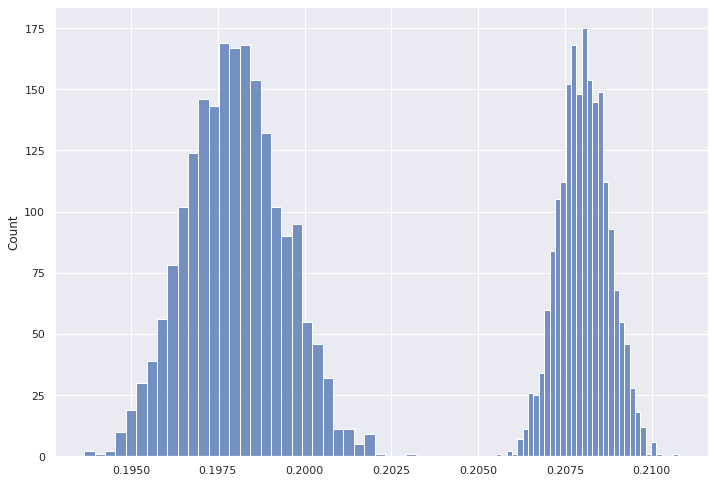

In [14]:
# формируем выборки глобальных значений CTR для  группы 1 и группы 2 и строим гистограммы
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

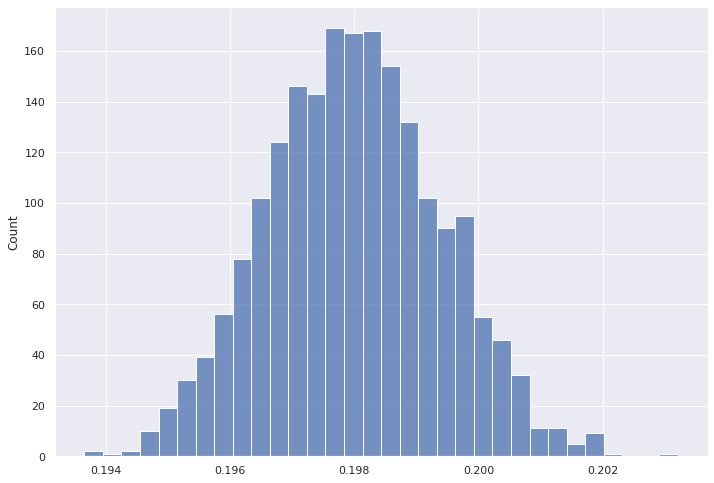

In [15]:
# чтобы убедиться,  что не произошло наложение гистограмм (для двух групп) 
# друг на друга, выведем гистограмму для второй  группы)
sns.histplot(ctr2)

In [16]:
# получение результатов t-test по группам 1 и 2  по глобальному ctr
stats.ttest_ind(ctr1, ctr2,
                equal_var=False)

Ttest_indResult(statistic=285.4476959749008, pvalue=0.0)

Выводы:
- так как мы строили распределение усредненного CTR по всем пользователям, попавшим в случайную подвыборку, то в каждом случае (если система сплитования работает хорошо и объекты из подгрупп с малым и высоким CTR вгруппе 2 распределялись равномерно) мы все-таки получаем "среднюю температуру по больнице", и распределение глобального CTR в группе 2 стало унимодальным, по среднему значению довольно близким к среднему в группе 1, к значению 0.2;
- то, что распределения глобалных CTR в группе 1 и 2 получились хорошо разделимыми (и гипотеза о равенстве средних глобальных CTR отвергается по t-критерию), позволяет (зная принцип вычисления глобальных CTR) высказать предположение о природе пользователей в подгруппах с малым и большим CTR в группе 2. Судя по всему, значительная часть пользователей, у которых в группе 2 малый CTR, имеют много просмотров  и уже относительно этого малое число лайков. Поэтому когда мы считаем глобальный  CTR как сумму лайков всех пользователей (в группе), деленную на сумму просмотров всех пользователей, число просмотров у пользователей с малым CTR "поглощает" (поскольку значительно превосходит) число просмотров у пользователей с большим CTR, поэтому значения глобального CTR практически не выходят за значения 0.202.  

С точки зрения выводов для приложения - такое  распределение показывает, что желание ставить лайки уменьшилось у наиболее активной части пользователей, имеющих наибольшее число просмотров. Думаю, это является рекомендацией к тому, чтобы новшество в приложение не внедрять. 

## Бакетное преобразование

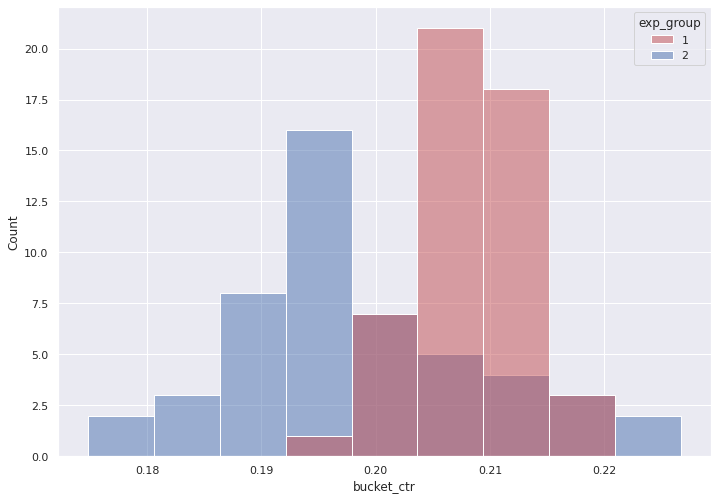

In [18]:
# создаем подключение, проверяем, что связь есть, смотрим,
# что данные возвращаются адекватные
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220920',
                      'user':'student', 
                      'password':'dpo_python_2020'
            }

q10 = """
        SELECT exp_group, bucket,
            sum(likes)/sum(views) as bucket_ctr,
            quantileExact(0.9)(ctr) as ctr9
        FROM (SELECT exp_group, 
                xxHash64(user_id)%50 as bucket,
                user_id,
                sum(action = 'like') as likes,
                sum(action = 'view') as views,
                likes/views as ctr
            FROM {db}.feed_actions 
            WHERE toDate(time) between '2022-09-03' and '2022-09-09'
                and exp_group in (1,2)
            GROUP BY exp_group, bucket, user_id)
        GROUP BY exp_group, bucket
    """
# гистограмма совмещенная
df_buc = ph.read_clickhouse(q10, connection=connection)
groups = sns.histplot(data = df_buc, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

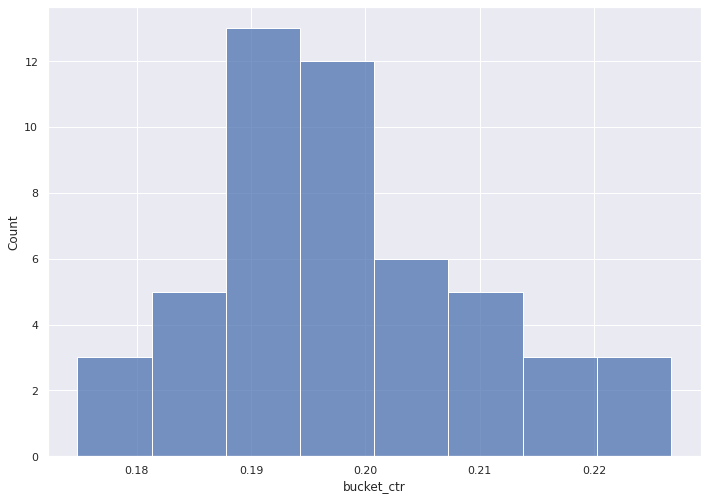

In [19]:
# гистограмма группы 2 
sns.histplot(df_buc[df_buc.exp_group == 2].bucket_ctr)

In [21]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df_buc[df_buc.exp_group == 1].bucket_ctr, 
                   df_buc[df_buc.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Вывод:  
а вот использование "метапользователя" (бакета), собранного из суммарной информации по 50 случайно (с использованиемтой же сплит системы, что и для разбиения на АА или АВ-группы) отобранным пользователям действительно позволяет уйти от двумодальности, и корректно применить тесты. Одннако в данном случае критерий Манна-Уитни говорит о том, что CTR в группе, которой показывали новый вариант рекомендаций, значимо меньше, чем CTR в той группе, где был прежний вариант.  

# Задача 3

## Выборки 1 и 2, линеаризированный CTR

In [22]:
# формируем выборки линеаризированных CTR для  группы 1 и группы 2 
linearized_likes_2= likes2 - global_ctr_1*views2 
linearized_likes_1= likes1 - global_ctr_1*views1 

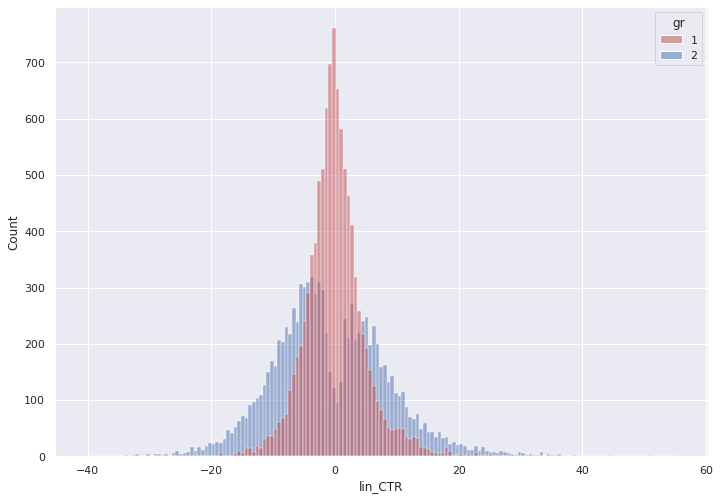

In [23]:
# и строим гистограммы
gr1 = [1 for i  in range(len(linearized_likes_1))]
gr2 = [2 for i  in range(len(linearized_likes_2))]
df_gr1 = zip(linearized_likes_1,gr1)
df_gr2 = zip(linearized_likes_2,gr2)
df1 = pd.DataFrame(df_gr1, columns=['lin_CTR', 'gr'])
df2 = pd.DataFrame(df_gr2, columns=['lin_CTR', 'gr'])
df_lin = pd.concat([df1, df2])

groups = sns.histplot(data = df_lin, 
              x='lin_CTR', 
              hue='gr', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)


In [24]:
# получение результатов t-test по группам 1 и 2  по линеаризированным ctr
stats.ttest_ind(linearized_likes_1, linearized_likes_2,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)

In [25]:
# вычисляем среднее линеаризированных лайков по группам 
(df1['lin_CTR'].mean(),df2['lin_CTR'].mean())

(-4.2580396110636028e-16, -0.6592771236485203)

Выводы:
- применение линеаризированных CTR (вместо обычных) сделал подгруппы (с меньшим и большим CTR) группы 2 не настолько хорошо разделимыми, но распределение в группе 2 все равно остается отчетливо двумодальным
- в данном случае в первой группе среднее  де-факторавно нулю, а во второй группе равно -0.66, и t-критерий находит между ними статистически значимые различия (pvalue=9.4394e-10 < 0.05), но, во-первых, t-критерий здесь также некорректно применять, как и в ситуации с обычным CTR, а во-вторых, разница средних не в пользу гипотезы  о том, что новый алгоритм улучшает CTR.
- в целом, анализируя график с гистограммами, можно заметить, что преобразование линеанеризации CTR позволяет увидеть, что в группе 2 подгруппа с малым значением CTR  дает больший вклад в  общую активность группы за счет того, что абсолютные значения лайков и просмотров в ней учитываются не только в виде взаимных отношений, но и непосредственно при вычислении, что позволяет лучше учитывать и саму активность пользователей.     

## Выборки 0 и 3, обычный CTR

In [26]:
# подключились к БД и выполнили запрос по извлечению всех пользователей в группе 0 и 3 
# в нужном временном интервале и информации по ним (ctr на каждого userа)
q2 = """
    SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-09-03' and '2022-09-09'
        and exp_group in (0,3)
    GROUP BY exp_group, user_id
    """
# создаем подключение, проверяем, что связь есть, смотрим,что данные возвращаются адекватные
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220920',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }


df_new = ph.read_clickhouse(q2, connection=connection)
# вывели число пользователей в получившихся группах
df_new.groupby('exp_group').count() 

,user_id,likes,views,ctr
exp_group,,,,
0,9999,9999,9999,9999
3,10049,10049,10049,10049


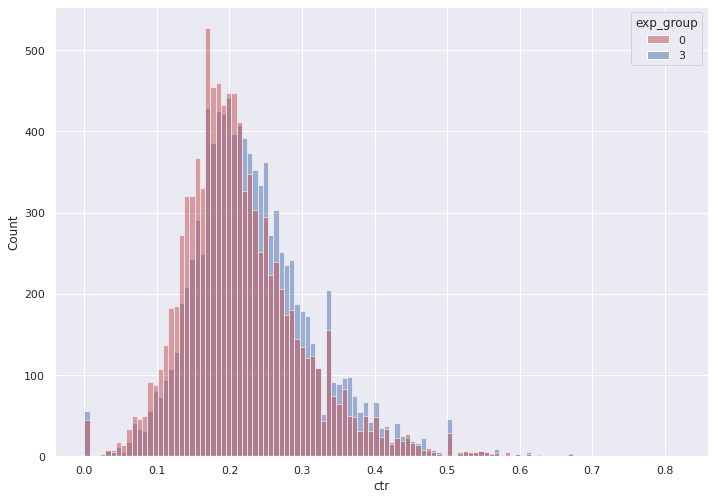

In [27]:
# гистограммы по обоим группам вместе (на одном рисунке)
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df_new, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)


In [28]:
# получение результатов t-test по группам 0 и 3  по показателю ctr
stats.ttest_ind(df_new[df_new.exp_group == 0].ctr,
                df_new[df_new.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [29]:
# получение результатов Манна-Уитни по группам 0 и 3  по показателю ctr
stats.mannwhitneyu(df_new[df_new.exp_group == 0].ctr, 
                   df_new[df_new.exp_group == 3].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43682792.0, pvalue=1.1952055473582936e-57)

In [60]:
# средние в группах по линеаризированным ctr
(df_new[df_new.exp_group == 0].ctr.mean(),df_new[df_new.exp_group == 3].ctr.mean())

(0.21594964998983304, 0.23262390914604023)

Выводы:
-	по обычному CTR оба метода (t-критерий и критерий Манна-Уитни) находят статистически значимые различия, причем среднее по CTR в группе, которой предложили новый алгоритм (группа 3) - выше;
-	графики также показывают смещение распределения CTR в группе 3 относительно группы 0 вправо, что согласуется с результатами по критериям;
-	графики не показывают критических отклонений эмпирических распределений от необходимого нормального закона, хотя отдельные выбросы наблюдаются как для группы 0, так и для группы 3, но в целом нет оснований не доверять результатам тестов.

## Выборки 0 и 3, линеаризированный CTR

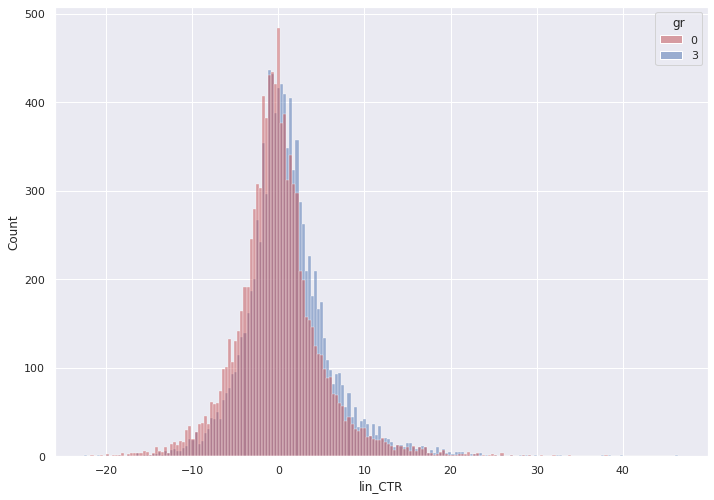

In [30]:
# формируем нужные выборки
likes0 = df_new[df_new.exp_group == 0].likes.to_numpy()
views0 = df_new[df_new.exp_group == 0].views.to_numpy()
likes3 = df_new[df_new.exp_group == 3].likes.to_numpy()
views3 = df_new[df_new.exp_group == 3].views.to_numpy()

global_ctr_0 = df_new[df_new.exp_group == 0].likes.sum()/df_new[df_new.exp_group == 0].views.sum()

# формируем выборки линеаризированных CTR для  группы 1 и группы 2 и строим гистограммы
linearized_likes_3= likes3 - global_ctr_0*views3 
linearized_likes_0= likes0 - global_ctr_0*views0 
gr0 = [0 for i  in range(len(linearized_likes_0))]
gr3 = [3 for i  in range(len(linearized_likes_3))]

df_gr0 = zip(linearized_likes_0,gr0)
df_gr3 = zip(linearized_likes_3,gr3)
df0 = pd.DataFrame(df_gr0, columns=['lin_CTR', 'gr'])
df3 = pd.DataFrame(df_gr3, columns=['lin_CTR', 'gr'])
df_lin_new = pd.concat([df0, df3])

groups = sns.histplot(data = df_lin_new, 
              x='lin_CTR', 
              hue='gr', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [31]:
# получение результатов t-test по группам 0 и 3  по линеаризированным ctr
stats.ttest_ind(linearized_likes_0, linearized_likes_3,
                equal_var=False)

Ttest_indResult(statistic=-15.21499546090383, pvalue=5.4914249479687664e-52)

In [32]:
# получение результатов Манна-Уитни по группам 0 и 3  по линеаризированным ctr
stats.mannwhitneyu(linearized_likes_0, linearized_likes_3,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43338326.0, pvalue=1.1517315029786597e-63)

In [33]:
(df0['lin_CTR'].mean(),df3['lin_CTR'].mean())

(7.205623902997716e-16, 1.0713337480659029)

Вывод:
- линеаризация привела к меньшему числу выбросов в эмпирических распределениях, что делает их еще более похожими на нормальный закон распределения;
- критерии также отвергли гипотезу о равенстве средних, что  позволяет говорить о  том, что CTR в группе с новым алгоритмов значимо больше, чем в группе с прежним.

# Общий вывод по анализу выборок 1 и 2

Моя рекомендация по тому, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит? - нет, на всех пользователей точно не стоит, так как наиболее активная их часть отреагировала негативно на новый алгоритм, гипотеза о том, что с новым алгоритмом CTR станет значимо больше, не подтвердилась.  

Единственное, что можно попытаться составить портрет типичного представителя двух подгрупп группы 2 по демографическим и техническим характеристикам. Если какой-то набор значений  характеристик позволит четко классифицировать пользователей на тех, у кого новый алгоритм  вызвал понижение CTR, и у кого вызвал повышение, то можно проанализировать уже эти характеристики. Если они окажутся техническими, то, возможно, понижение CTR связано с какой-то спецификой применения нового алгоритма на определенных устройствах, и эту проблему можно найти и устранить. Если выделятся демографические характеристики, то можно подумать о возможной дальнейшей персониикации алгоритма приложения под определенный тип пользователя, что позволит избежать просадки CTR у одних пользователей и сохранить прирост CTR у других.       